# Week 6 Workshop: Multi-Armed Bandits

In this notebook, we will explore the core concepts of **multi-armed bandits**, focusing on:

1. Definitions and properties (based on the recitation session).
2. Action-value methods and uncertainty in bandits.
3. Exploration-exploitation strategies:
   - $\epsilon$-greedy
   - Optimistic initial values
   - Upper Confidence Bound (UCB)
   - Thompson Sampling
4. Contextual bandits
5. Real-world applications:
   - Recommender Systems
   - Search
6. Summary and key takeaways

We'll show **pure Python implementations** and **Gymnasium-based** implementations, so you can see how each algorithm might look in a more standardized RL environment setup.


> **Note:** In typical RL frameworks, a bandit is treated as either a single-step environment (reset after each pull) or a multi-step environment with a fixed horizon. The examples below choose a **multi-step environment with a fixed horizon** to mimic `num_steps` pulls in a single episode.



By the end of this notebook, you should:
- Understand the **multi-armed bandit problem** and how it differs from full RL (non-associative property).
- Implement various exploration methods ($\epsilon$-greedy, UCB, etc.), both purely and via Gymnasium.
- Get an introduction to **contextual bandits** and how they generalize the bandit paradigm.
- See how these ideas apply to **recommender systems** and **search**.

## 1. Setup and Imports

We'll import:
- `numpy` for numerical operations
- `matplotlib` for plotting
- `gymnasium` to demonstrate how to wrap the bandit environment in the standard Gym interface

We also set a random seed for reproducibility.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

np.random.seed(42)

## 2. Multi-Armed Bandits: Recap

### 2.1 Definition of the Problem and Non-Associativity Property

From the recitation session:

A **multi-armed bandit (MAB)** is a fundamental reinforcement learning setting modeling **decision-making under uncertainty**. The problem is often described as having $k$ different slot machines (arms), each with an **unknown** distribution of rewards.

- We have **$ k $** arms/actions.
- Each arm $ a $ has an **unknown expected reward** $ q_*(a) $:
  $$
  q_*(a) = \mathbb{E}[R \mid A = a],
  $$
  where $ R $ is the reward for choosing action $ A $.
- We want to **maximize the cumulative reward**:
  $$
  G = \sum_{t=1}^{T} R_t.
  $$
- We **do not** know $ q_*(a) $ and must **estimate** these values over time.

**Non-Associativity**:
- Unlike a full RL problem, multi-armed bandits are **non-associative**—there are no distinct states or transitions.
- The best action does not depend on any "state"; the challenge is figuring out which action yields the highest expected reward overall.

### 2.2 Action-Value Methods and Types

From the recitation session:

We define the **action-value** $ Q_t(a) $ as our estimate of $ q_*(a) $. Using **sample-average methods**:
$$
Q_t(a) = \frac{1}{N_t(a)} \sum_{i=1}^{N_t(a)} R_i,
$$
where $ N_t(a) $ is the number of times action $ a $ has been chosen up to time $ t $, and $ R_i $ are the observed rewards.

**Incremental Update Rule** (to avoid storing entire histories):
$$
Q_{t+1}(a) = Q_t(a) + \frac{1}{N_t(a)}(R_t - Q_t(a)).
$$

#### Constant Step-Size for Nonstationary Problems
When rewards change over time, we use **constant step-size** $ \alpha $:
$$
Q_{t+1}(a) = Q_t(a) + \alpha (R_t - Q_t(a)).
$$
- Large $\alpha$ gives more weight to recent data, useful for **nonstationary** environments.

### 2.3 Exploration-Exploitation Dilemma and Uncertainty

From the recitation session:

A core challenge is balancing **exploration** and **exploitation**:
- **Exploration**: try different actions to reduce uncertainty in their value estimates.
- **Exploitation**: select the best-known action to maximize immediate reward.

Mathematically, if an action is not selected often, $ N_t(a) $ remains small, so the **uncertainty** in its estimate is large. An agent must ensure all actions are sufficiently explored to accurately approximate $ q_*(a) $.

## 3. Exploration in Bandits

We now discuss the exploration strategies described in the recitation session, plus some additional ones and extra details. We'll first show **plain Python** implementations, then **Gymnasium-based** versions.

### 3.1 $\epsilon$-Greedy

From the recitation:

> **$\epsilon$-greedy**:
> $$
> A_t =
> \begin{cases}
> \arg\max_a Q_t(a), & \text{with probability } 1-\epsilon \\
> \text{random } a, & \text{with probability } \epsilon.
> \end{cases}
> $$

- Simple to implement.
- Guarantees each arm is sampled (with probability $\epsilon$).
- Can be inefficient if $\epsilon$ is large because it spends too much time on suboptimal arms.

#### 3.1.1 Plain Python: Bernoulli Bandit and $\epsilon$-Greedy

In [ ]:
class BernoulliBandit:
    """
    A simple k-armed Bernoulli bandit.
    Each arm i has a probability p[i] of returning reward=1.
    """
    def __init__(self, p):
        self.p = np.array(p)
        self.k = len(p)

    def step(self, action):
        # Returns 1 with probability p[action], else 0
        return 1 if np.random.rand() < self.p[action] else 0

def epsilon_greedy(bandit, num_steps=1000, epsilon=0.1):
    """
    Epsilon-greedy action selection.
    bandit: an instance of BernoulliBandit
    num_steps: total number of pulls
    epsilon: exploration rate
    """
    k = bandit.k
    Q = np.zeros(k) # Estimated values of arms
    N = np.zeros(k) # Count of pulls for each arm

    rewards_history = []

    for _ in range(num_steps):
        # Explore vs Exploit
        if np.random.rand() < epsilon:
            action = np.random.randint(k) # Explore
        else:
            action = np.argmax(Q) # Exploit

        reward = bandit.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action] # Update estimate
        rewards_history.append(reward)

    return np.array(rewards_history), Q

# Demo (plain Python)
p = [0.1, 0.3, 0.8]
bandit = BernoulliBandit(p)
rewards, Q_est = epsilon_greedy(bandit, num_steps=1000, epsilon=0.1)
print(f"Estimated Q-values: {Q_est}")
print(f"Total reward: {rewards.sum()} out of 1000 pulls")

Estimated Q-values: [0.0625     0.36585366 0.80241493]
Total reward: 749 out of 1000 pulls


#### 3.1.2 Gymnasium-Based Implementation: $\epsilon$-Greedy

Below, we wrap the Bernoulli bandit logic in a Gymnasium environment. In this approach:
- We have a single episode of length `num_steps`.
- The environment’s `action_space` is `Discrete(k)`.
- Observations are trivial (we’ll just return a dummy array).
- After each `step(action)`, we increment an internal step count and eventually set `done=True` when `num_steps` is reached.

Then we run an $\epsilon$-greedy policy in the **standard Gym loop**.

In [ ]:
class BernoulliBanditEnv(gym.Env):
    """
    Gymnasium environment for a k-armed Bernoulli bandit.
    The episode length is fixed to num_steps.
    """
    def __init__(self, p, num_steps=1000):
        super().__init__()
        self.p = np.array(p)
        self.k = len(p)
        self.num_steps = num_steps

        # Define action & observation space
        self.action_space = spaces.Discrete(self.k)
        # We'll return a dummy observation (e.g., shape (1,))
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        self.current_step = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        # Return a dummy observation
        return np.array([0.0], dtype=np.float32), {}

    def step(self, action):
        reward = 1 if np.random.rand() < self.p[action] else 0
        self.current_step += 1
        done = (self.current_step >= self.num_steps)
        # We don't have a meaningful observation, so just return a dummy
        obs = np.array([0.0], dtype=np.float32)
        info = {}
        return obs, float(reward), done, False, info

# Gym-based epsilon-greedy
def epsilon_greedy_gym(env, epsilon=0.1):
    k = env.action_space.n
    Q = np.zeros(k)
    N = np.zeros(k)
    rewards_history = []

    obs, info = env.reset()
    done = False
    step_count = 0

    while not done:
        step_count += 1
        # Explore vs Exploit
        if np.random.rand() < epsilon:
            action = np.random.randint(k)
        else:
            action = np.argmax(Q)

        obs, reward, done, truncated, info = env.step(action)

        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards_history.append(reward)

        if done or truncated:
            break

    return np.array(rewards_history), Q

# Demo (Gym)
p = [0.1, 0.3, 0.8]
env = BernoulliBanditEnv(p, num_steps=1000)
gym_rewards, gym_Q = epsilon_greedy_gym(env, epsilon=0.1)
print(f"[GYM] Estimated Q-values: {gym_Q}")
print(f"[GYM] Total reward: {gym_rewards.sum()} out of 1000 pulls")

[GYM] Estimated Q-values: [0.0625     0.33962264 0.80294451]
[GYM] Total reward: 731.0 out of 1000 pulls


### 3.2 Optimistic Initial Values

From the recitation session:

> **Optimistic Initial Values**: Initialize $ Q_1(a) $ to a high value (e.g., 5), so the agent is initially optimistic about all actions, forcing early exploration.

#### 3.2.1 Plain Python: Optimistic Initial Values

In [ ]:
def optimistic_initial_values(bandit, num_steps=1000, initial_value=5.0):
    k = bandit.k
    Q = np.ones(k) * initial_value # Optimistic values
    N = np.zeros(k)
    rewards_history = []

    for _ in range(num_steps):
        action = np.argmax(Q) # Always pick the best-known arm
        reward = bandit.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action] # Update estimate
        rewards_history.append(reward)

    return np.array(rewards_history), Q

# Demo (plain Python)
p = [0.1, 0.3, 0.8]
bandit = BernoulliBandit(p)
rewards_opt, Q_opt = optimistic_initial_values(bandit, num_steps=1000, initial_value=5.0)
print(f"Estimated Q-values: {Q_opt}")
print(f"Total reward: {rewards_opt.sum()} out of 1000 pulls")

Estimated Q-values: [0.         0.         0.80561122]
Total reward: 804 out of 1000 pulls


#### 3.2.2 Gymnasium-Based Implementation: Optimistic Initial Values

We’ll reuse `BernoulliBanditEnv`. We just need to set initial estimates to a high value in the Gym loop.

In [ ]:
def optimistic_initial_values_gym(env, initial_value=5.0):
    k = env.action_space.n
    Q = np.ones(k) * initial_value
    N = np.zeros(k)
    rewards_history = []

    obs, info = env.reset()
    done = False
    step_count = 0

    while not done:
        step_count += 1
        action = np.argmax(Q)
        obs, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards_history.append(reward)

        if done or truncated:
            break

    return np.array(rewards_history), Q

# Demo (Gym)
p = [0.1, 0.3, 0.8]
env = BernoulliBanditEnv(p, num_steps=1000)
gym_rewards_opt, gym_Q_opt = optimistic_initial_values_gym(env, initial_value=5.0)
print(f"[GYM] Estimated Q-values: {gym_Q_opt}")
print(f"[GYM] Total reward: {gym_rewards_opt.sum()} out of 1000 pulls")

[GYM] Estimated Q-values: [0.11222445 0.         0.        ]
[GYM] Total reward: 112.0 out of 1000 pulls


### 3.3 Upper Confidence Bound (UCB)

From the recitation session:

> **UCB**:
> Improves on $\epsilon$-greedy by considering uncertainty in action values:
> $$
> A_t = \arg\max_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right].
> $$
> Where:
> - $ Q_t(a) $ is the estimated action value.
> - $ \sqrt{\frac{\ln t}{N_t(a)}} $ is the confidence bound.
> - $ c $ controls exploration.
- The second term which is the **confidence bound**, shrinks as $ N_t(a) $ grows.
- $ c $ is a hyperparameter controlling the degree of exploration.

#### 3.3.1 Plain Python: UCB Implementation

In [ ]:
def ucb(bandit, num_steps=1000, c=2.0):
    k = bandit.k
    Q = np.zeros(k)
    N = np.zeros(k)
    rewards_history = []

    for t in range(1, num_steps + 1):
        if t <= k:
            action = t - 1
        else:
            confidence = c * np.sqrt(np.log(t) / (N + 1e-9))
            ucb_values = Q + confidence
            action = np.argmax(ucb_values)

        reward = bandit.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action] # Update estimate
        rewards_history.append(reward)

    return np.array(rewards_history), Q

# Demo (plain Python)
p = [0.1, 0.3, 0.8]
bandit = BernoulliBandit(p)
rewards_ucb, Q_ucb = ucb(bandit, num_steps=1000, c=2.0)
print(f"Estimated Q-values: {Q_ucb}")
print(f"Total reward: {rewards_ucb.sum()} out of 1000 pulls")

Estimated Q-values: [0.15       0.33333333 0.80760626]
Total reward: 750 out of 1000 pulls


#### 3.3.2 Gymnasium-Based Implementation: UCB

We again use `BernoulliBanditEnv` and incorporate the same UCB formula in the Gym loop.

In [ ]:
def ucb_gym(env, c=2.0):
    k = env.action_space.n
    Q = np.zeros(k)
    N = np.zeros(k)
    rewards_history = []

    obs, info = env.reset()
    done = False
    t = 0

    while not done:
        t += 1
        if t <= k:
            action = t - 1
        else:
            confidence = c * np.sqrt(np.log(t) / (N + 1e-9))
            ucb_values = Q + confidence
            action = np.argmax(ucb_values)

        obs, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards_history.append(reward)

        if done or truncated:
            break

    return np.array(rewards_history), Q

# Demo (Gym)
p = [0.1, 0.3, 0.8]
env = BernoulliBanditEnv(p, num_steps=1000)
gym_rewards_ucb, gym_Q_ucb = ucb_gym(env, c=2.0)
print(f"[GYM] Estimated Q-values: {gym_Q_ucb}")
print(f"[GYM] Total reward: {gym_rewards_ucb.sum()} out of 1000 pulls")

[GYM] Estimated Q-values: [0.08333333 0.30769231 0.78642937]
[GYM] Total reward: 730.0 out of 1000 pulls


### 3.4 Thompson Sampling (Additional)

**Thompson Sampling** is a popular approach that uses **Bayesian updating** of reward distributions.


> [A Tutorial on Thompson Sampling, by Russo et al.](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf)



1.  **A short explanation:**

In the Thompson Sampling implementation, **α (alpha)** and **β (beta)** are the parameters of the **Beta distribution** used as a prior (and posterior) for each arm's probability of reward. In the context of a Bernoulli bandit:

*   α (alpha) represents the count of "successes" (i.e. rewards of 1) plus one (initially, it starts at 1).
*   β (beta) represents the count of "failures" (i.e. rewards of 0) plus one (also starting at 1).



2.  **Core Idea** (Very Short):

At each time step, for each **arm**, we sample a **probability** from its **Beta(α, β) distribution**. Then, we choose the arm with **the highest sampled probability**. This naturally balances exploration (arms with uncertain outcomes have **wider** Beta distributions, which might yield **high** samples) and exploitation (arms with many successes have higher mean values).

In the code snippets below the main idea is, after pulling an arm:

*   If a reward is received (i.e. reward = 1), the corresponding α is incremented.
*   If no reward is received (reward = 0), the corresponding β is incremented.

This Bayesian update refines our estimate of each arm's probability over time.

#### 3.4.1 Plain Python: Thompson Sampling

In [ ]:
def thompson_sampling(bandit, num_steps=1000):
    k = bandit.k
    alpha = np.ones(k)
    beta = np.ones(k)
    rewards_history = []

    for _ in range(num_steps):
        # Sample from Beta distributions
        sampled_q = np.random.beta(alpha, beta)
        action = np.argmax(sampled_q)
        reward = bandit.step(action)

        if reward == 1:
            alpha[action] += 1
        else:
            beta[action] += 1
        rewards_history.append(reward)

    return np.array(rewards_history), alpha, beta

# Demo (plain Python)
p = [0.1, 0.3, 0.8]
bandit = BernoulliBandit(p)
rewards_ts, alpha_ts, beta_ts = thompson_sampling(bandit, 1000)
print(f"Total reward with Thompson Sampling: {rewards_ts.sum()}")
print(f"Final alpha: {alpha_ts}, final beta: {beta_ts}")

Total reward with Thompson Sampling: 803
Final alpha: [  1.   2. 803.], final beta: [  5.   6. 189.]


#### 3.4.2 Gymnasium-Based Implementation: Thompson Sampling

We’ll maintain separate Beta($\alpha$,$\beta$) parameters for each arm, sampling from them in each environment step.

In [ ]:
def thompson_sampling_gym(env):
    k = env.action_space.n
    alpha = np.ones(k)
    beta = np.ones(k)
    rewards_history = []

    obs, info = env.reset()
    done = False
    while not done:
        sampled_q = np.random.beta(alpha, beta)
        action = np.argmax(sampled_q)
        obs, reward, done, truncated, info = env.step(action)

        if reward == 1:
            alpha[action] += 1
        else:
            beta[action] += 1
        rewards_history.append(reward)

        if done or truncated:
            break

    return np.array(rewards_history), alpha, beta

# Demo (Gym)
p = [0.1, 0.3, 0.8]
env = BernoulliBanditEnv(p, num_steps=1000)
gym_rewards_ts, gym_alpha_ts, gym_beta_ts = thompson_sampling_gym(env)
print(f"[GYM] Total reward with Thompson Sampling: {gym_rewards_ts.sum()}")
print(f"[GYM] Final alpha: {gym_alpha_ts}, final beta: {gym_beta_ts}")

[GYM] Total reward with Thompson Sampling: 795.0
[GYM] Final alpha: [  1.   4. 793.], final beta: [  6.   5. 197.]


## 4. Contextual Bandits

In **contextual bandits**, each action’s reward depends on an observed **context** (features). This is more realistic (e.g., user profile for recommender systems).

### 4.1 Contextual Bandit Example (Plain Python)
Below, each arm has a weight vector. The environment returns a random context $ x $, and the probability of reward is $ \sigma(w_a^T x) $, where $ \sigma $ is the logistic function.

In [ ]:
class ContextualBanditEnv:
    def __init__(self, weights):
        """
        weights: array of shape (k, d).
        Each row corresponds to an arm's weight vector.
        """
        self.weights = weights
        self.k = weights.shape[0]
        self.d = weights.shape[1]

    def get_context(self):
        # Return a random context
        return np.random.randn(self.d)

    def step(self, action, context):
        w = self.weights[action]
        p = 1.0 / (1.0 + np.exp(- w.dot(context)))
        return 1 if np.random.rand() < p else 0


### 4.2 A Simple LinUCB-Like Approach (Plain Python)

We assume each arm’s reward is linear in the context, plus a confidence bonus for exploration.

**Core Idea:**

The core idea of this LinUCB-like approach is to use a linear model for each arm that predicts the expected reward given a context, and then add a confidence bonus to that prediction to encourage exploration. In the code:

*   For each arm, we maintain a matrix $A$ (which tracks the covariance of the contexts) and a vector $b$ (which accumulates the weighted rewards).
*   The estimated parameter $θ$ for each arm is computed as $θ=A^{−1}b$.
*   For a given context $x$, the predicted reward is $θ^Tx$, and the confidence bonus is $𝛼\sqrt{x^TA^{-1}x}$.
*   The arm chosen is the one that maximizes the sum of the predicted reward and the bonus.
*   After taking an action and receiving a reward, the algorithm updates $A$ and $b$ for the selected arm.

This method naturally balances exploitation (choosing the arm with the highest predicted reward) and exploration (choosing arms with high uncertainty).

In [ ]:
def linucb(env, num_steps=1000, alpha=1.0):
    k = env.k
    d = env.d

    A = [np.eye(d) for _ in range(k)]
    b = [np.zeros(d) for _ in range(k)]
    rewards_history = []

    for _ in range(num_steps):
        x = env.get_context()
        p_t = []
        for a in range(k):
            A_inv = np.linalg.inv(A[a])
            theta_a = A_inv.dot(b[a])
            mean = theta_a.dot(x)
            conf = alpha * np.sqrt(x.T.dot(A_inv).dot(x))
            p_t.append(mean + conf)

        action = np.argmax(p_t)
        reward = env.step(action, x)
        rewards_history.append(reward)

        A[action] += np.outer(x, x)
        b[action] += reward * x

    return np.array(rewards_history)

# Demo (plain Python)
weights = np.array([
    [2.0, -1.0],  # arm 0
    [-1.0, 2.0],  # arm 1
    [1.0, 1.0]    # arm 2
])
ctx_env = ContextualBanditEnv(weights)
rewards_linucb = linucb(ctx_env, num_steps=1000, alpha=1.0)
print("Total reward with LinUCB in contextual bandit:", rewards_linucb.sum())

Total reward with LinUCB in contextual bandit: 727


### 4.3 Gymnasium-Based Contextual Bandit

We can also wrap this contextual bandit logic in a Gym environment. Each step:
1. We provide an observation = the current context.
2. The agent chooses an action.
3. We compute a reward.
4. We sample a new context for the next step.
5. The episode ends after `num_steps`.

In [ ]:
class ContextualBanditGymEnv(gym.Env):
    def __init__(self, weights, num_steps=1000):
        super().__init__()
        self.weights = weights
        self.k = weights.shape[0]
        self.d = weights.shape[1]
        self.num_steps = num_steps
        self.current_step = 0

        self.action_space = spaces.Discrete(self.k)
        # Observation is a d-dimensional context
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.d,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        # Sample an initial context
        self.context = np.random.randn(self.d).astype(np.float32)
        return self.context, {}

    def step(self, action):
        # Probability of reward = sigmoid(w_a . context)
        w = self.weights[action]
        p = 1.0 / (1.0 + np.exp(- w.dot(self.context)))
        reward = 1.0 if np.random.rand() < p else 0.0

        self.current_step += 1
        done = (self.current_step >= self.num_steps)
        info = {}

        # Sample next context
        self.context = np.random.randn(self.d).astype(np.float32)
        return self.context, reward, done, False, info

#### 4.3.1 Gymnasium LinUCB Demo
We now adapt the **LinUCB** approach to use `ContextualBanditGymEnv`. We'll do a single episode of length `num_steps` and keep track of the contexts at each step.

In [ ]:
def linucb_gym(env, alpha=1.0):
    k = env.action_space.n
    d = env.observation_space.shape[0]
    A = [np.eye(d) for _ in range(k)]
    b = [np.zeros(d) for _ in range(k)]
    rewards_history = []

    obs, info = env.reset()
    done = False

    while not done:
        x = obs  # current context
        p_t = []
        for a in range(k):
            A_inv = np.linalg.inv(A[a])
            theta_a = A_inv.dot(b[a])
            mean = theta_a.dot(x)
            conf = alpha * np.sqrt(x.T.dot(A_inv).dot(x))
            p_t.append(mean + conf)

        action = np.argmax(p_t)
        new_obs, reward, done, truncated, info = env.step(action)
        rewards_history.append(reward)

        # Update
        A[action] += np.outer(x, x)
        b[action] += reward * x

        obs = new_obs
        if done or truncated:
            break

    return np.array(rewards_history)

# Demo (Gym)
weights = np.array([
    [2.0, -1.0],  # arm 0
    [-1.0, 2.0],  # arm 1
    [1.0, 1.0]    # arm 2
])
env = ContextualBanditGymEnv(weights, num_steps=1000)
gym_rewards_linucb = linucb_gym(env, alpha=1.0)
print("[GYM] Total reward with LinUCB in contextual bandit:", gym_rewards_linucb.sum())

[GYM] Total reward with LinUCB in contextual bandit: 715.0


## 5. Bandit Applications
In this section, we provide **practical examples** for two major real-world applications of bandits:
- Recommender Systems
- Search

We’ll show both **pure Python** and **Gymnasium** approaches.

### 5.1 Recommender Systems

A recommender system often picks an item (action) to recommend for a particular user, receives feedback (reward), and aims to maximize user satisfaction (clicks, watch time, etc.).

#### 5.1.1 Pure Python Example [EXTRA]
We'll simulate a scenario where we have `k` items to recommend, and each user is described by a **context** vector. We'll keep it simple:
- Each item has a weight vector.
- The user context is sampled randomly.
- The probability of a click (reward=1) is `sigmoid(w_item . context)`.
We'll implement a minimal function to **run an $\epsilon$-greedy** approach for demonstration.

In [ ]:
class RecommenderSystemBandit:
    """
    Pure Python bandit environment for a recommender system.
    """
    def __init__(self, item_weights, context_dim=2, num_users=1000):
        """
        item_weights: np.array of shape (k, context_dim)
        context_dim: dimension of each user's feature vector
        num_users: how many user interactions we simulate
        """
        self.item_weights = item_weights
        self.k = item_weights.shape[0]
        self.context_dim = context_dim
        self.num_users = num_users
        self.current_step = 0

    def get_context(self):
        # Sample a random user feature vector
        return np.random.randn(self.context_dim)

    def step(self, action, user_context):
        """
        Probability of reward = sigmoid(item_weights[action] . user_context)
        """
        w = self.item_weights[action]
        p = 1.0 / (1.0 + np.exp(- w.dot(user_context)))
        reward = 1 if np.random.rand() < p else 0
        self.current_step += 1
        done = (self.current_step >= self.num_users)
        return reward, done

def run_epsilon_greedy_recommender(env, epsilon=0.1):
    k = env.k
    Q = np.zeros(k)
    # The number of times each 'action' has been selected,
    # each element in N corresponds to a particular arm.
    N = np.zeros(k)
    rewards_history = []

    while True:
        context = env.get_context()
        if np.random.rand() < epsilon:
            action = np.random.randint(k)
        else:
            action = np.argmax(Q)

        reward, done = env.step(action, context)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards_history.append(reward)

        if done:
            break

    return np.array(rewards_history), Q

# Demo: RecommenderSystemBandit with k=3 items
item_weights = np.array([
    [1.5, 0.5],   # item 0
    [-0.5, 1.2], # item 1
    [0.8, 0.8]   # item 2
])
rec_env = RecommenderSystemBandit(item_weights, context_dim=2, num_users=1000)
recomm_rewards, recomm_Q = run_epsilon_greedy_recommender(rec_env, epsilon=0.1)
print("Recommender (pure Python) total reward:", recomm_rewards.sum())
print("Final Q estimates:", recomm_Q)

Recommender (pure Python) total reward: 476
Final Q estimates: [0.46927374 0.48042705 0.47592593]


#### 5.1.2 Gymnasium Example [EXTRA]
We create a Gym environment where each step corresponds to recommending an item for a randomly sampled user context. We’ll do a short **$\epsilon$-greedy** run.

In [ ]:
class RecommenderSystemGymEnv(gym.Env):
    def __init__(self, item_weights, context_dim=2, num_users=1000):
        super().__init__()
        self.item_weights = item_weights
        self.k = item_weights.shape[0]
        self.context_dim = context_dim
        self.num_users = num_users
        self.current_step = 0

        self.action_space = spaces.Discrete(self.k)
        # Observation is the user context
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(self.context_dim,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.context = np.random.randn(self.context_dim).astype(np.float32)
        return self.context, {}

    def step(self, action):
        w = self.item_weights[action]
        p = 1.0 / (1.0 + np.exp(- w.dot(self.context)))
        reward = 1.0 if np.random.rand() < p else 0.0
        self.current_step += 1
        done = (self.current_step >= self.num_users)
        info = {}

        # sample next user context
        self.context = np.random.randn(self.context_dim).astype(np.float32)
        return self.context, reward, done, False, info

def run_epsilon_greedy_recommender_gym(env, epsilon=0.1):
    k = env.action_space.n
    Q = np.zeros(k)
    N = np.zeros(k)
    rewards_history = []

    obs, info = env.reset()
    done = False
    while not done:
        if np.random.rand() < epsilon:
            action = np.random.randint(k)
        else:
            action = np.argmax(Q)

        new_obs, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards_history.append(reward)

        obs = new_obs
        if done or truncated:
            break

    return np.array(rewards_history), Q

# Demo: RecommenderSystemGymEnv
item_weights = np.array([
    [1.5, 0.5],   # item 0
    [-0.5, 1.2], # item 1
    [0.8, 0.8]   # item 2
])
env_rec = RecommenderSystemGymEnv(item_weights, context_dim=2, num_users=1000)
rec_gym_rewards, rec_gym_Q = run_epsilon_greedy_recommender_gym(env_rec, epsilon=0.1)
print("[GYM Recommender] total reward:", rec_gym_rewards.sum())
print("[GYM Recommender] final Q estimates:", rec_gym_Q)

[GYM Recommender] total reward: 517.0
[GYM Recommender] final Q estimates: [0.51923077 0.52070263 0.44680851]


### 5.2 Search

A simplified "search" bandit scenario might involve multiple **ranking strategies** or **candidate documents**. We pick which strategy or document to display for a given query, and get a click/no-click reward. Below, we provide a toy model:
- We have `k` different "search strategies."
- Each query is a context vector.
- Probability of a click is a logistic function of the chosen strategy’s weight.

#### 5.2.1 Pure Python Example [EXTRA]
We'll do the same structure as the Recommender, but we’ll call it "SearchBandit."

In [ ]:
class SearchBandit:
    """
    Pure Python environment to simulate 'search strategies' bandit.
    """
    def __init__(self, strategy_weights, context_dim=2, num_queries=500):
        self.strategy_weights = strategy_weights
        self.k = strategy_weights.shape[0]
        self.context_dim = context_dim
        self.num_queries = num_queries
        self.current_step = 0

    def get_context(self):
        return np.random.randn(self.context_dim)

    def step(self, action, query_context):
        w = self.strategy_weights[action]
        p = 1.0 / (1.0 + np.exp(- w.dot(query_context)))
        reward = 1 if np.random.rand() < p else 0
        self.current_step += 1
        done = (self.current_step >= self.num_queries)
        return reward, done

def run_thompson_search(env):
    """
    We'll demonstrate Thompson Sampling here.
    """
    k = env.k
    alpha = np.ones(k)
    beta = np.ones(k)
    rewards_history = []

    while True:
        query_context = env.get_context()
        sampled_q = np.random.beta(alpha, beta)
        action = np.argmax(sampled_q)
        reward, done = env.step(action, query_context)
        if reward == 1:
            alpha[action] += 1
        else:
            beta[action] += 1
        rewards_history.append(reward)

        if done:
            break

    return np.array(rewards_history), alpha, beta

# Demo: 3 search strategies
strategy_weights = np.array([
    [1.0, 1.0],   # strategy 0
    [-0.5, 2.0], # strategy 1
    [2.0, -0.2]  # strategy 2
])
search_env = SearchBandit(strategy_weights, context_dim=2, num_queries=500)
search_rewards, alpha_s, beta_s = run_thompson_search(search_env)
print("Search (pure Python) total reward:", search_rewards.sum())
print("Alpha:", alpha_s, "Beta:", beta_s)

Search (pure Python) total reward: 264
Alpha: [114.  68.  85.] Beta: [98. 69. 72.]


#### 5.2.2 Gymnasium Example [EXTRA]
We create a `SearchGymEnv` where each step is a query, and we choose among multiple strategies. We’ll reuse Thompson Sampling again.

In [ ]:
class SearchGymEnv(gym.Env):
    def __init__(self, strategy_weights, context_dim=2, num_queries=500):
        super().__init__()
        self.strategy_weights = strategy_weights
        self.k = strategy_weights.shape[0]
        self.context_dim = context_dim
        self.num_queries = num_queries
        self.current_step = 0

        self.action_space = spaces.Discrete(self.k)
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(context_dim,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.context = np.random.randn(self.context_dim).astype(np.float32)
        return self.context, {}

    def step(self, action):
        w = self.strategy_weights[action]
        p = 1.0 / (1.0 + np.exp(- w.dot(self.context)))
        reward = 1.0 if np.random.rand() < p else 0.0
        self.current_step += 1
        done = (self.current_step >= self.num_queries)
        info = {}

        # get new query context
        self.context = np.random.randn(self.context_dim).astype(np.float32)
        return self.context, reward, done, False, info

def run_thompson_search_gym(env):
    k = env.action_space.n
    alpha = np.ones(k)
    beta = np.ones(k)
    rewards_history = []

    obs, info = env.reset()
    done = False
    while not done:
        sampled_q = np.random.beta(alpha, beta)
        action = np.argmax(sampled_q)
        new_obs, reward, done, truncated, info = env.step(action)
        if reward == 1:
            alpha[action] += 1
        else:
            beta[action] += 1
        rewards_history.append(reward)

        obs = new_obs
        if done or truncated:
            break

    return np.array(rewards_history), alpha, beta

# Demo: SearchGymEnv
strategy_weights = np.array([
    [1.0, 1.0],   # strategy 0
    [-0.5, 2.0], # strategy 1
    [2.0, -0.2]  # strategy 2
])
env_search = SearchGymEnv(strategy_weights, context_dim=2, num_queries=500)
search_gym_rewards, alpha_search_gym, beta_search_gym = run_thompson_search_gym(env_search)
print("[GYM Search] total reward:", search_gym_rewards.sum())
print("[GYM Search] alpha:", alpha_search_gym, "beta:", beta_search_gym)

[GYM Search] total reward: 268.0
[GYM Search] alpha: [ 21.  65. 185.] beta: [ 22.  52. 161.]


## 6. Comparing the Algorithms

Let’s do a quick empirical comparison among:
- $\epsilon$-greedy
- Optimistic Initial Values
- UCB
- Thompson Sampling

using the **plain Python** `BernoulliBandit` environment.

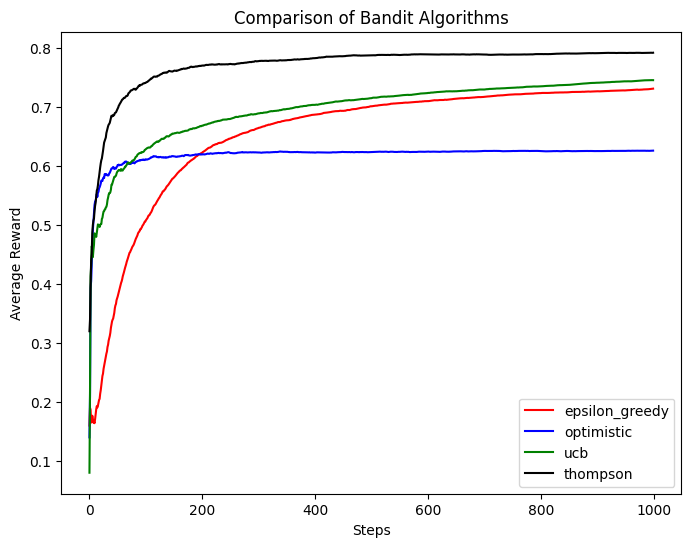

In [ ]:
def run_bandit_algorithms(p, num_steps=1000, runs=50):
    """
    Compare multiple algorithms on the same Bernoulli bandit.
    Returns average reward across runs for each algorithm.
    """
    avg_rewards = {
        'epsilon_greedy': np.zeros(num_steps),
        'optimistic': np.zeros(num_steps),
        'ucb': np.zeros(num_steps),
        'thompson': np.zeros(num_steps)
    }

    for _ in range(runs):
        # 1) Epsilon-Greedy
        bandit = BernoulliBandit(p)
        rew_eps, _ = epsilon_greedy(bandit, num_steps, epsilon=0.1)

        # 2) Optimistic
        bandit = BernoulliBandit(p)
        rew_opt, _ = optimistic_initial_values(bandit, num_steps, initial_value=5.0)

        # 3) UCB
        bandit = BernoulliBandit(p)
        rew_ucb, _ = ucb(bandit, num_steps, c=2.0)

        # 4) Thompson Sampling
        bandit = BernoulliBandit(p)
        rew_ts, _, _ = thompson_sampling(bandit, num_steps)

        avg_rewards['epsilon_greedy'] += rew_eps
        avg_rewards['optimistic'] += rew_opt
        avg_rewards['ucb'] += rew_ucb
        avg_rewards['thompson'] += rew_ts

    # Average across runs
    for key in avg_rewards:
        avg_rewards[key] /= runs

    return avg_rewards

p = [0.1, 0.3, 0.8]
results = run_bandit_algorithms(p, num_steps=1000, runs=50)

colors = ["red", "blue", "green", "black"]
# Plot average reward over time
plt.figure(figsize=(8,6))
for idx, (label, rew) in enumerate(results.items()):
    cum_mean = np.cumsum(rew) / (np.arange(len(rew)) + 1)
    plt.plot(cum_mean, label=label, color=colors[idx])

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Comparison of Bandit Algorithms")
plt.legend()
plt.show()

## 7. Summary (Recitation Session + Additional)

### From Recitation Session Recap

| **Method**                  | **Exploration Type**               | **Pros**                               | **Cons**                               |
|----------------------------|-------------------------------------|----------------------------------------|----------------------------------------|
| **$\epsilon$-greedy**    | Random exploration                  | Simple, ensures some exploration       | Wastes time on bad actions             |
| **Optimistic Initial Values** | High initial estimates             | Systematic, encourages exploration     | Not as adaptive in nonstationary envs  |
| **UCB**                    | Confidence-based exploration        | Theoretical guarantees (low regret)    | More complex, tricky to scale          |
| **Thompson Sampling**      | Bayesian approach (Beta-Bernoulli)  | Natural exploration, strong performance| Implementation a bit more involved     |

### Key Takeaways
1. **Multi-armed bandits** are the simplest reinforcement learning setting but illustrate the **exploration-exploitation** dilemma clearly.
2. **The Recitation Session** underscores the **non-associative** nature: no states, no transitions—just repeated action selection.
3. Various **exploration strategies** exist:
   - $\epsilon$-greedy
   - Optimistic initial values
   - UCB
   - Thompson Sampling (Bayesian)
4. **Contextual bandits** extend MAB by including a **context** (features) to inform which arm to pull.
5. Real-world **bandit applications** (recommender systems, search, etc.) can be tackled with the same techniques, using domain-specific reward definitions and contexts.

### Next Steps for Enthusiats
- Integrate more advanced methods for **nonstationary** bandits (e.g., sliding windows, constant step-size).
- Explore **contextual bandits** in more complex environments (e.g., large-scale real data).
- Consider bridging bandits to **full RL**: in full RL, each "state" becomes a context, but we also have transitions and possibly function approximation for large state/action spaces.
